# Actual plots

## init

In [2]:
from matplotlib import pyplot as plt
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import pickle

sns.set_theme(palette="colorblind", style="ticks")


initial_params_actual = {\
    "h" : {"thick": 0.0012, "thin": 0.0002},
    "E_lookup" : {"70_S":2508*3,"70_H":16082*3,"80_S":9344*3,"80_H":17507*3},
    "E_lookup_max" : {"70_S":(2508+21)*3,"70_H":(16082+167)*3,"80_S":(9344+50)*3,"80_H":(17507+200)*3},
    "E_lookup_min" : {"70_S":(2508-21)*3,"70_H":(16082-167)*3,"80_S":(9344-50)*3,"80_H":(17507-200)*3},
    "upsilon" : (0.059+0.016)/2, # from Park et al, Ups_s = Ups_SV + Ups_SL / 2
    "gamma" : 0.072, # from https://en.wikipedia.org/wiki/Surface_tension
}

initial_params = initial_params_actual.copy()

source_dir = Path(r"D:\Publications\Paper4-Wetting-ridge\raw_data")

eval_dir = Path(r"D:\Publications\Paper4-Wetting-ridge\raw_data\compare_magn\eval")
if not eval_dir.exists(): eval_dir.mkdir()

sources = source_dir.rglob("*.tif")
sources = list(sources)

order = ["80_S_thin", "80_S_thick", "80_H_thin", "80_H_thick"]

# plot_out_dir = Path(r"D:\Publications\Paper4-Wetting-ridge\compare_magn_plots")
# if not plot_out_dir.exists(): plot_out_dir.mkdir()


## fit

In [3]:
from data_types import RidgeFit, RidgeFitMethod
from skimage.transform import rescale
# Extract ridge from images and store as csv
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import pickle
from ridge_extractor import extract_ridge_from_image
from ridge_profile_fit import fit_profile_style,fit_profile
from ridge_models import style_exact
# from scipy.signal import savgol_filter
import asyncio
import traceback

# https://stackoverflow.com/a/59385935/9173710

def background(f):
    def wrapped(*args, **kwargs):
        return asyncio.get_event_loop().run_in_executor(None, f, *args, **kwargs)
    return wrapped

@background
def fit_style(file):
    try:
        target_file = eval_dir / file.name
        ridge, image, circ_params, rim_binarized, r2, pixelscale, stdev, sterr = \
                extract_ridge_from_image(file, robust=True, threshold=0.7, use_kmeans=False, butterworth_cutoff=0.01, gamma_correction=3)
        yc,xc,r = circ_params
        # rolling average
        x_r, y_r = ridge
        # y_r = np.convolve(y_r, np.ones(10), 'same') / 10
        # y_r = savgol_filter(y_r, 500, 2)
        print(f"{file.stem} Center: ({yc},{xc}) Radius: {r} R2: {r2}")
        df = pd.DataFrame({"x":x_r,"y":y_r})
        df.to_csv(target_file.with_suffix(".rdg"), sep=";")

        # fits: dict[str, RidgeFit] = fit_profile(target_file.with_suffix(".rdg"),models=["style"], **initial_params)
        fits: dict[str, RidgeFit] = fit_profile_style(target_file.with_suffix(".rdg"), **initial_params, fix_upsilon=False, fix_h=False)


        pickle.dump((yc,xc,r,r2,image,pixelscale,rim_binarized,fits,ridge,stdev,sterr), open(target_file.with_suffix(".pkl"), "wb"))

    except Exception as e:
            print(str(e), traceback.format_exc())
            print(file)

futures = list()

sem = asyncio.Semaphore(4)
for file in sources:
    async with sem:
        futures.append(fit_style(file))

res = await asyncio.gather(*futures)


DIPlib -- a quantitative image analysis library
Version 3.4.3 (Mar 21 2024)
For more information see https://diplib.org
80_H_1_thin_magn_120mT_f.ome Center: (1405,1455) Radius: 910 R2: 0.9988816761829437
80_H_1 - 0.6
80_S_1_thick_magn_120mT_f.ome Center: (1449,1432) Radius: 1022 R2: 0.9570983776011008
80_S_1 - 0.6
80_H_1_thick_magn_quer_f.ome Center: (1431,1373) Radius: 1087 R2: 0.998183290154984
80_H_1 - 0.7
Style:		R2 0.572
`gtol` termination condition is satisfied.

Style:		R2 -1.488
`gtol` termination condition is satisfied.

Style:		R2 -3.615
`gtol` termination condition is satisfied.

80_H_1_thick_magn_120mT_f.ome Center: (1385,1412) Radius: 870 R2: 0.9750002228511829
80_H_1 - 0.5
Style:		R2 -1.029
`gtol` termination condition is satisfied.

80_H_1_thick_mag_220mT_f.ome Center: (1518,1408) Radius: 1044 R2: 0.9879102572925186
80_H_1 - 0.6
80_S_1_thick_magn_270mT_f.ome Center: (1437,1423) Radius: 927 R2: 0.9996273093799212
Style:		R2 -0.755
`gtol` termination condition is satisfied

## data conversion

In [12]:
from ridge_models import style_exact
df_dict = {}
df_list = []
model_dict = {}
for file in eval_dir.rglob("*.pkl"):
    if "_test" in str(file) or "_first" in str(file) or "_second" in str(file):
        continue

    with open(file, "rb") as f:
        yc,xc,r,r2,image,pixelscale,rim_binarized,fits,ridge,stdev,sterr = pickle.load(f)

    model = fits["style"]
    Fe, G, vol, th, _, magntype, *_ = Path(file).stem.split("_")

    fit_x = np.linspace(model.x_values.min(), model.x_values.max(), 250)
    x,y = ridge
    y = y*1e6
    stdev = stdev*1e6
    sterr = sterr*1e6
    norm_x = x / model.radius
    # fit_y = 1e6*style_exact(x, model.gamma, model.radius, *model.popt)
    # fit_y_max = 1e6*style_exact(x, model.gamma, model.radius, model.popt[0], initial_params_actual["E_lookup_max"][f"{Fe}_{G}"], model.popt[2])
    # fit_y_min = 1e6*style_exact(x, model.gamma, model.radius, model.popt[0], initial_params_actual["E_lookup_min"][f"{Fe}_{G}"], model.popt[2])
    # fit_y_th = 1e6*style_exact(x, model.gamma, model.radius, initial_params_actual["gamma"], initial_params_actual["E_lookup"][f"{Fe}_{G}"], initial_params_actual["h"][f"{th}"])
    # df = pd.DataFrame({"x":x, "norm_x":norm_x, "y":y, "fit_y":fit_y, "fit_y_max":fit_y_max, "fit_y_min":fit_y_min, "fit_y_th":fit_y_th, "model":"style", "Fe":Fe, "G":G, "vol":vol, "th":th, "magn":magntype, "R2":model.r2})
    df = pd.DataFrame({"x":[x], "norm_x":[norm_x], "y":[y], "y_err": [sterr], "model":"style", "Fe":Fe, "G":G, "vol":vol, "th":th, "magn":magntype, "R2":model.r2})
    # df["rolling_y"] = df["y"].rolling(50,center=True).mean()
    # df["rolling_y_stdev"] = df["y"].rolling(50,center=True).std()
    # df_dict[f"{magntype}_{G}_{th}"] = df
    # model_dict[f"{magntype}_{G}_{th}"] = model

    df_list.append(df)
    print(f"{file.stem} - R2: {model.r2:.3f} - r {model.radius} - {model.popt}")

master_data = pd.concat(df_list, ignore_index=True)
master_data["magn"] = master_data["magn"].replace({"quer":"$\\rightarrow$120","120mT":"$\\uparrow$120","220mT":"$\\uparrow$220","270mT":"$\\uparrow$270","380mT":"$\\uparrow$380"})
master_data["th"] = master_data["th"].replace({"thick":"$h =$ 1.2 mm","thin":"$h =$ 0.2 mm"})
master_data["G"] = master_data["G"].replace({"H":"17.5 kPa","S":"9.3 kPa"})
master_data["peak_height"] = master_data["y"].apply(lambda x: max(x))
master_data["peak_height_err"] = master_data["y_err"].apply(lambda x: max(x))
# master_data["fit_y_max"] = master_data["fit_y"].apply(lambda x: max(x))


master_data.to_json(source_dir / "master_data.json")


fit_max = dict()
for G in ["S","H"]:
    for th in ["thin","thick"]:
        fit_max[f"{G}_{th}"] = 1e6*style_exact(x, model.gamma, model.radius, initial_params_actual["gamma"], initial_params_actual["E_lookup"][f"{Fe}_{G}"], initial_params_actual["h"][f"{th}"]).max()

80_H_1_thick_magn_120mT_f.ome - R2: -1.029 - r 0.000542 - [3.7500e-02 5.2521e+04 1.2000e-03]
80_H_1_thick_magn_270mT_f.ome - R2: 0.050 - r 0.000704 - [3.7500e-02 5.2521e+04 1.2000e-03]
80_H_1_thick_magn_quer_f.ome - R2: -3.615 - r 0.000704 - [3.7500e-02 5.2521e+04 1.2000e-03]
80_H_1_thick_mag_220mT_f.ome - R2: -0.755 - r 0.000633 - [3.7500e-02 5.2521e+04 1.2000e-03]
80_H_1_thin_magn_120mT_f.ome - R2: 0.572 - r 0.000564 - [3.7500e-02 5.2521e+04 2.0000e-04]
80_H_1_thin_magn_270mT_f.ome - R2: 0.331 - r 0.000669 - [3.7500e-02 5.2521e+04 2.0000e-04]
80_H_1_thin_magn_380mT_f.ome - R2: 0.428 - r 0.000655 - [1.13337453e-02 3.06159763e+04 6.85204464e-04]
80_H_1_thin_magn_quer_f.ome - R2: 0.406 - r 0.000658 - [3.7500e-02 5.2521e+04 2.0000e-04]
80_H_1_thin_mag_220mT_f.ome - R2: 0.396 - r 0.000738 - [3.7500e-02 5.2521e+04 2.0000e-04]
80_S_1_thick_magn_120mT_f.ome - R2: -1.488 - r 0.000646 - [3.7500e-02 2.8032e+04 1.2000e-03]
80_S_1_thick_magn_270mT_f.ome - R2: 0.002 - r 0.000583 - [3.7500e-02 2.80

## Experimental plots

### 2d ridge

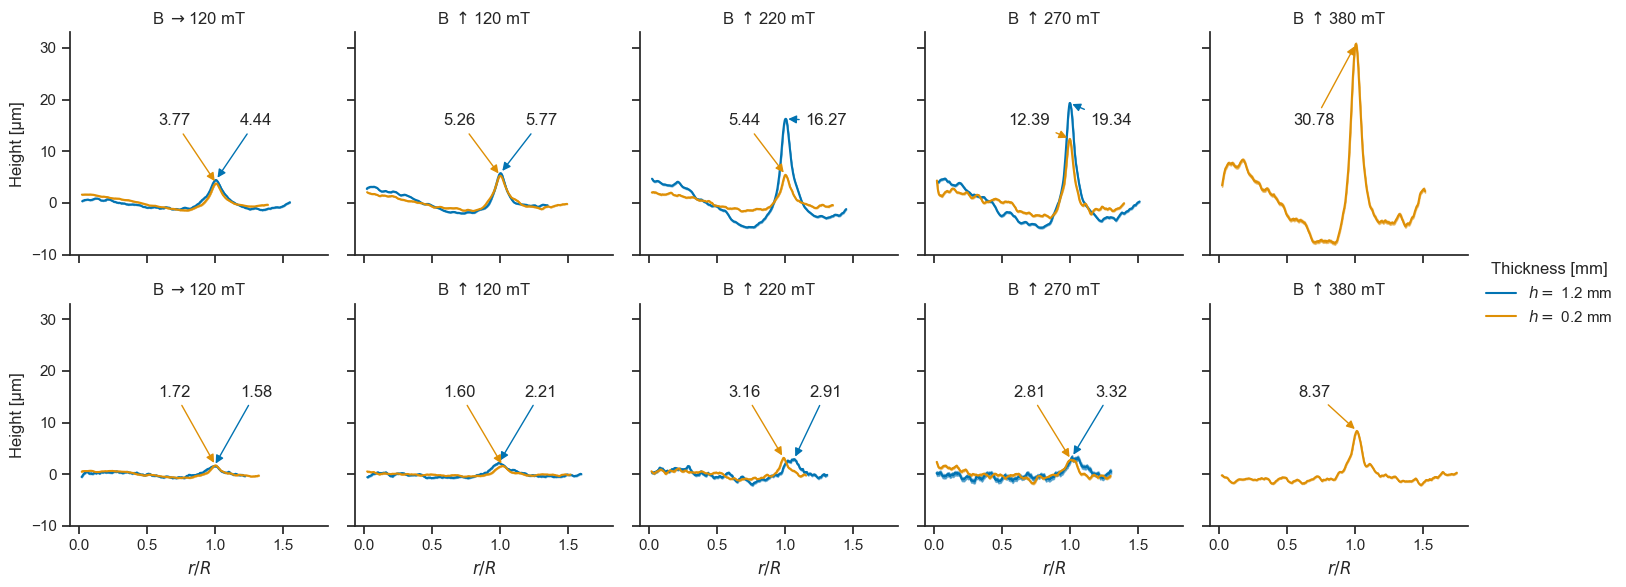

In [13]:
import seaborn as sns

sns.set_theme(palette="colorblind", style="ticks")
def plot_nested_data(*args,**kwargs):
    color = kwargs.pop("color")
    data = kwargs.pop("data")
    x = np.asarray(data[args[0]].values[0])
    y = np.asarray(data[args[1]].values[0])
    y_err = np.asarray(data["y_err"].values[0])
    rolling = pd.Series(y).rolling(25, center=True)
    y = rolling.mean()
    stdev_y = pd.Series(y_err).std()
    #
    plt.fill_between(x, y-stdev_y, y+stdev_y, alpha=0.5, color=color)
    plt.plot(x,y, color=color, **kwargs)
    if "label" in kwargs:
        # if kwargs["label"] == "0.2":
        #     plt.annotate(f"{np.max(y):0.2f}", (x[np.argmax(y)], np.max(y)), textcoords="offset points", xytext=(15,10), ha='center', arrowprops=dict(arrowstyle='-|>', color=color))
        # else:
        #     plt.annotate(f"{np.max(y):0.2f}", (x[np.argmax(y)], np.max(y)), textcoords="offset points", xytext=(-15,10), ha='center', arrowprops=dict(arrowstyle='-|>', color=color))
        if kwargs["label"] == "$h =$ 0.2 mm":
            plt.annotate(f"{np.max(y):0.2f}", (x[np.argmax(y)], np.max(y)), textcoords="data", xytext=(0.7,15), ha='center', arrowprops=dict(arrowstyle='-|>', color=color))
        else:
            plt.annotate(f"{np.max(y):0.2f}", (x[np.argmax(y)], np.max(y)), textcoords="data", xytext=(1.3,15), ha='center', arrowprops=dict(arrowstyle='-|>', color=color))
    plt.legend()

grid = sns.FacetGrid(data=master_data, col="magn", row="G", hue="th", sharex=True, sharey=True, aspect=1, height=3, legend_out=True, 
                     col_order= ["$\\rightarrow$120","$\\uparrow$120","$\\uparrow$220","$\\uparrow$270","$\\uparrow$380"],
                     row_order=["9.3 kPa","17.5 kPa"])

grid.set_titles(template="B {col_name} mT")
grid.map_dataframe(plot_nested_data, "norm_x", "y")
for info,ax in grid.axes_dict.items():
    if info[1] != "$\\rightarrow$120 mT": continue
    plt.sca(ax)
    plt.annotate(info[0], (-0.8, .5), xycoords="axes fraction", ha='center', va='center', fontsize=12, rotation=90)


# grid.figure.tight_layout()
grid.add_legend(title="Thickness [mm]" )
grid.set_xlabels("$r/R$")
grid.set_ylabels("Height [µm]")
# grid.savefig(plot_out_dir / "ridge_profiles_comp.pdf")


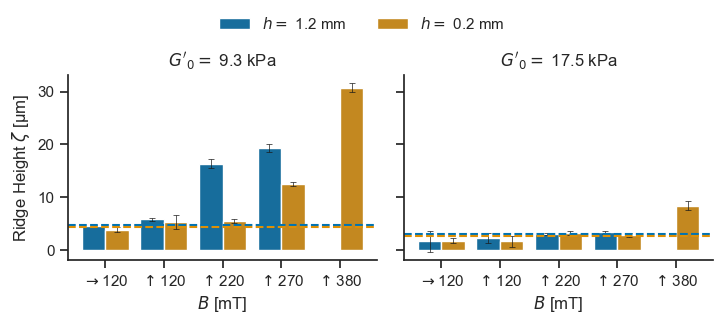

In [14]:
def catplot_error(err, hue=None, col=None, row=None, data:pd.DataFrame =None, **kwargs) -> sns.FacetGrid:
    if err is None: raise ValueError("err not given")

    bar_lbl_fmt = kwargs.pop('bar_lbl_fmt',"%.0f")
    facet: sns.FacetGrid = sns.catplot(data=data, col=col, row=row, hue=hue, **kwargs)
    ax_arr = facet.axes
    _error_df = data.copy(True)

    _error_df.sort_values(hue,inplace=True)
    _error_grps = _error_df.groupby(col)

    for ax, grp  in zip(ax_arr.ravel(order='F'), _error_grps.groups):
        # error bar
        x_coords = [p.get_x() + 0.5*p.get_width() for p in ax.patches]
        y_coords = [p.get_height() for p in ax.patches]

        err_val = _error_grps.get_group(grp)[err]

        plt.sca(ax)
        plt.errorbar(x=x_coords[:len(err_val)], y=y_coords[:len(err_val)], yerr=err_val, fmt="none", c="k", capsize=2, elinewidth=.5, capthick=.5)


    return facet

ordered_data = master_data.sort_values(by=["magn","G","th"], key=lambda x: x.map({"$\\rightarrow$120":0,"$\\uparrow$120":1,"$\\uparrow$220":2,"$\\uparrow$270":3}))

ordered_data["peak_height_roll"] = ordered_data["y"].apply(lambda x: pd.Series(np.asarray(x)).rolling(25, center=True).mean().max())
ordered_data["peak_height_roll_err"] = ordered_data["y_err"].apply(lambda x: pd.Series(np.asarray(x)).rolling(25, center=True).mean().max())
sns.set_theme(palette="colorblind", style="ticks")

hline = master_data.groupby(["G","th"])

grid = catplot_error(data=ordered_data, x="magn", y="peak_height_roll", err="peak_height_roll_err", hue="th", col="G", kind="bar", 
                     sharey=True, aspect=1, height=3, legend_out=True, col_order=["9.3 kPa","17.5 kPa"])
# iterate through axes

for ax in grid.axes.ravel():
    if  "9.3 kPa" in ax.get_title():
        softness = "S"
    else:
        softness = "H"

    palette = sns.color_palette()
    ax.axhline(fit_max[f"{softness}_thick"], color=palette[0], linestyle="--")
    ax.axhline(fit_max[f"{softness}_thin"], color=palette[1], linestyle="--")
    # add annotations
    # for c in ax.containers:
    #     # add custom labels with the labels=labels parameter if needed
    #     # labels = [f'{round(h,1):.1f}' if (h := v.get_height()) > 0 else '' for v in c]
    #     # ax.bar_label(c, label_type='edge', labels=labels)
    # ax.margins(y=0.2)
# grid.figure.tight_layout()
# grid.legend.set_title("Thickness [mm]")
# legend on top
# grid.add_legend(title="Thickness [mm]", loc="upper center", bbox_to_anchor=(0.5, 1.1), ncol=2)
sns.move_legend(grid, "upper center", bbox_to_anchor=(0.5, 1.1), ncol=2, title=None)
# grid.legend.set_title("Thickness [mm]")
grid.set_titles(col_template="$G'_0=$ {col_name}", row_template="")
grid.set_xlabels("$B$ [mT]")
grid.set_ylabels("Ridge Height $\\zeta$ [µm]")
plt.tight_layout()
# grid.savefig(plot_out_dir / "peak_compare_magn.pdf")

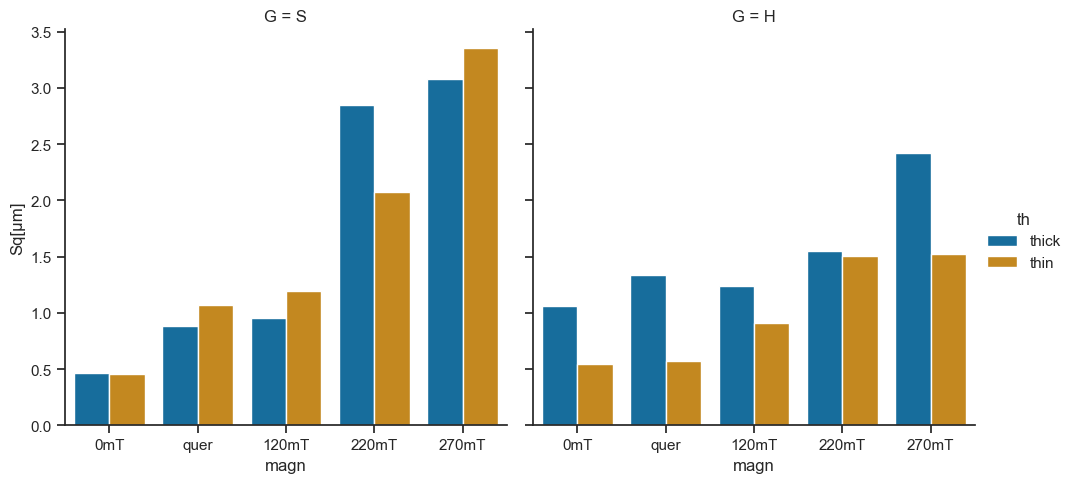

In [ ]:
import pandas as pd
import seaborn as sns
# df = pd.read_csv(r"D:\Messungen\Profilometry\Lasermikroskop\Wetting_Ridge\compare_quer_low_B\roughness_vert_vs_quer.csv", sep=",",header=0)
# df2 = pd.read_csv(r"D:\Messungen\Profilometry\Lasermikroskop\Wetting_Ridge\compare_quer_low_B\roughness_vals.csv", sep=",",header=0)
# df3 = pd.read_csv(r"D:\Messungen\Profilometry\Lasermikroskop\Wetting_Ridge\compare_quer_low_B\roughness_rest_meas.csv", sep=",",header=0)
# df4 = pd.read_csv(r"D:\Messungen\Profilometry\Lasermikroskop\Wetting_Ridge\compare_quer_low_B\roughness_recheck.csv", sep=",",header=0)

# df = pd.concat([df,df2,df3,df4])



# df["G"] = df["Dateiname"].str.split("_").str[1]
# df["th"] = df["Dateiname"].str.split("_").str[3]
# df["magn"] = df["Dateiname"].str.split("_").str[5]
# df["id"] = df["G"] + "_" + df["th"] + "_" + df["magn"]

# dupl = df.duplicated(subset="id", keep="last")
# df = df[~dupl]

# df = df.sort_values(by=["magn"], key=lambda x: x.map({"0mT":0,"quer":1,"120mT":2,"220mT":3,"270mT":4}))
df = pd.read_csv(source_dir / "roughness.csv")


sns.set_theme(palette="colorblind", style="ticks")
sns.catplot(data=df, x="magn", y="Sq[μm]", col="G",  hue="th", kind="bar" )

# df[["Sq[μm]", "G", "th", "magn"]].to_csv(source_dir / "roughness.csv", index=False)